In [3]:
%matplotlib inline

import pandas as pd
import numpy as np

import os
import gc
import feather

import matplotlib
import matplotlib.pyplot as plt

pd.set_option("max_colwidth", -1)
pd.set_option("max_columns", 500)
pd.set_option("max_rows", 500)

from tqdm import tqdm_notebook as tqdm
import lightgbm as lgb

In [4]:
plt.style.use('fivethirtyeight')
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

In [5]:
target = 'GrocerySales'

In [6]:
train = pd.read_csv("Train.csv", index_col=None)
print(train.shape)
train.head()

(692, 2)


,Day,GrocerySales
0,1,8418.59
1,2,8447.47
2,3,8336.49
3,4,8579.17
4,5,8524.31


In [7]:
test = pd.read_csv("Test.csv", index_col=None)
print(test.shape)
test.head()

(90, 1)


,Day
0,693
1,694
2,695
3,696
4,697


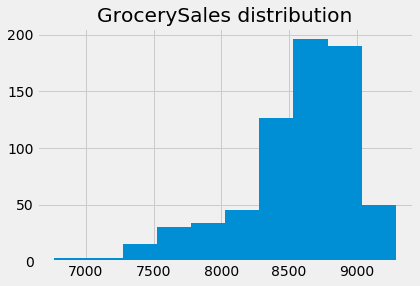

In [8]:
train[target].hist()
plt.title(f'{target} distribution')
plt.show()

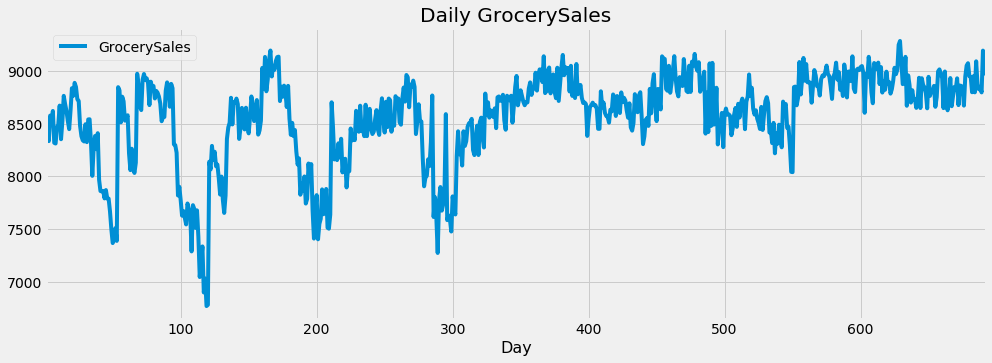

In [9]:
train.set_index('Day').plot(figsize=(15,5))
plt.title(f'Daily {target}')
plt.show()

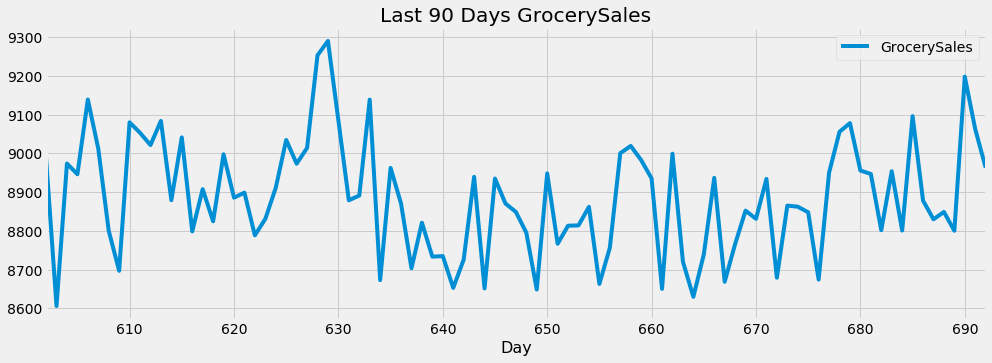

In [10]:
from datetime import timedelta
tmp = train.copy()
tmp = tmp[tmp.Day>=tmp.Day.max()-90]
tmp.set_index('Day').plot(figsize=(15,5))
plt.title(f'Last 90 Days {target}')
plt.show()

In [11]:
def plot_ma(series, window):
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving Average Window = {}".format(window))
    plt.plot(rolling_mean, label="Rolling Mean Trend")
    
    plt.plot(series[window:], label="Actual", color='orange')

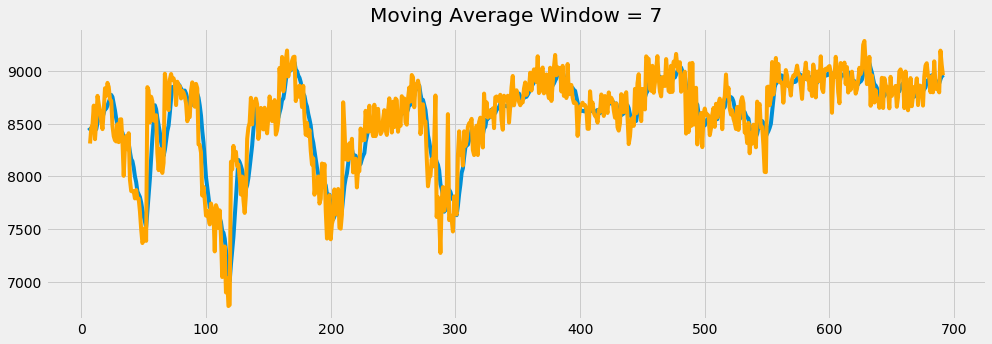

In [12]:
plot_ma(train[target], 7) 

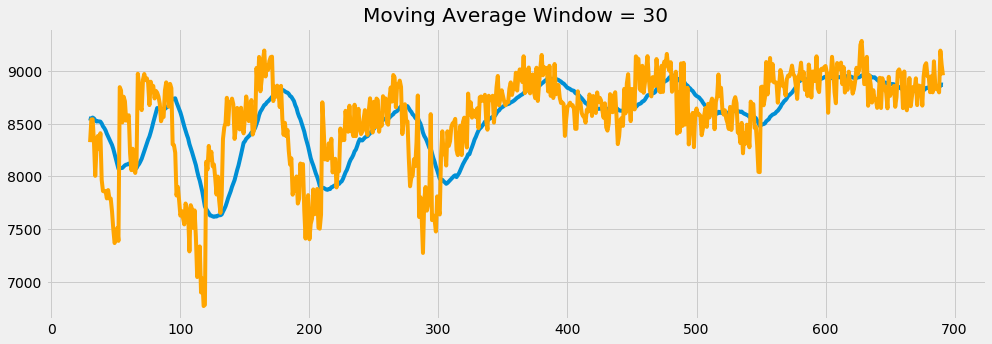

In [13]:
plot_ma(train[target], 30) 

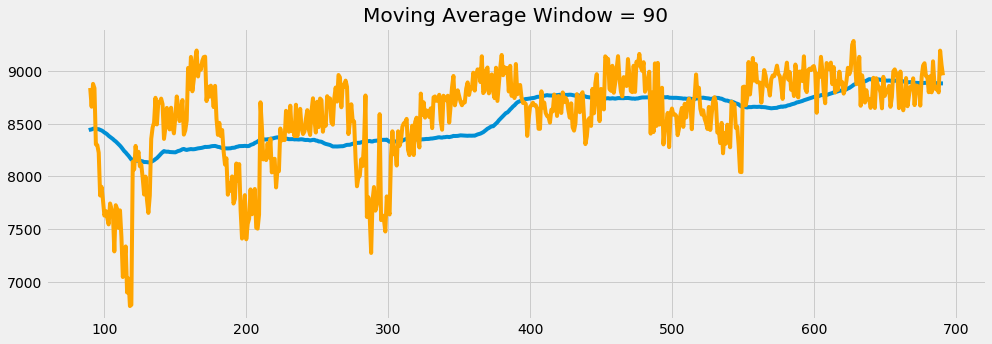

In [14]:
plot_ma(train[target], 90) 

* When we applied quarterly smoothing we see a slightly upward trend.

In [15]:
def plot_ewm(series, window, alpha):
    plt.figure(figsize=(15,5))
    plt.title("EWM with alpha:{}".format(alpha))    
    plt.plot(range(len(series)), series.shift(window).ewm(alpha=alpha).mean(), label=f"EWM {alpha}")
    plt.plot(range(len(series)), series, label='Actual', color='orange')
    plt.legend()
    plt.show()

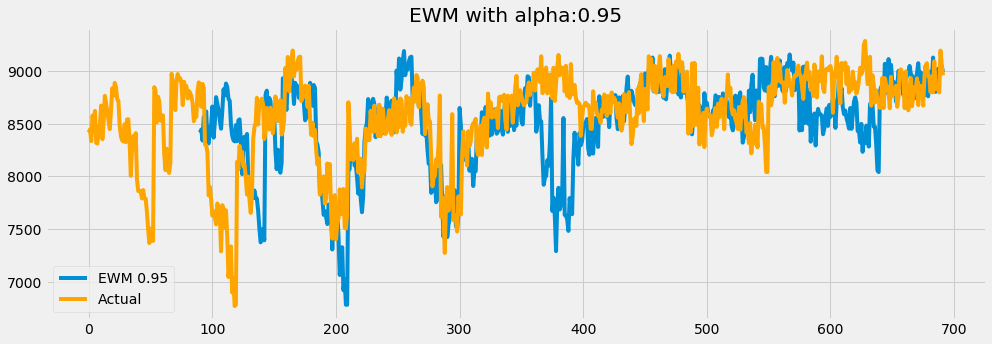

In [16]:
plot_ewm(train[target], 90, 0.95)

In [17]:
from sklearn.metrics import median_absolute_error, mean_squared_error

def root_mean_squared_error(y_true, y_pred): 
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [18]:
# test = train[-90:]
# train = train[:-90]

In [19]:
data = pd.concat((train, test), axis=0, sort=False, ignore_index=True).copy()

for i in range(90, 120):
    data["lag_{}".format(i)] = data[target].shift(i)

# data['dayofweek'] = data['Day'] % 7
data = data.drop('Day', axis=1)
# data[target] = np.sqrt(data[target])
# data['rolling_mean_30days'] = data[target].shift(90).rolling(window=30).mean()
# data['rolling_std_30days'] = data[target].shift(90).rolling(window=30).std()

# data['ewm_alpha0.95'] = data[target].shift(90).ewm(alpha=0.95).mean()
# data['ewm_std_alpha0.95'] = data[target].shift(90).ewm(alpha=0.95).std()

data.tail()

,GrocerySales,lag_90,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96,lag_97,lag_98,lag_99,lag_100,lag_101,lag_102,lag_103,lag_104,lag_105,lag_106,lag_107,lag_108,lag_109,lag_110,lag_111,lag_112,lag_113,lag_114,lag_115,lag_116,lag_117,lag_118,lag_119
777,NaN,8848.98,8829.95,8878.27,9096.06,8800.98,8953.92,8801.88,8946.92,8955.81,9078.06,9055.75,8950.12,8674.47,8848.05,8862.45,8865.31,8679.34,8934.20,8831.17,8852.32,8766.00,8668.82,8936.77,8739.22,8629.93,8720.86,8999.19,8650.53,8935.37,8982.75
778,NaN,8800.45,8848.98,8829.95,8878.27,9096.06,8800.98,8953.92,8801.88,8946.92,8955.81,9078.06,9055.75,8950.12,8674.47,8848.05,8862.45,8865.31,8679.34,8934.20,8831.17,8852.32,8766.00,8668.82,8936.77,8739.22,8629.93,8720.86,8999.19,8650.53,8935.37
779,NaN,9197.99,8800.45,8848.98,8829.95,8878.27,9096.06,8800.98,8953.92,8801.88,8946.92,8955.81,9078.06,9055.75,8950.12,8674.47,8848.05,8862.45,8865.31,8679.34,8934.20,8831.17,8852.32,8766.00,8668.82,8936.77,8739.22,8629.93,8720.86,8999.19,8650.53
780,NaN,9062.44,9197.99,8800.45,8848.98,8829.95,8878.27,9096.06,8800.98,8953.92,8801.88,8946.92,8955.81,9078.06,9055.75,8950.12,8674.47,8848.05,8862.45,8865.31,8679.34,8934.20,8831.17,8852.32,8766.00,8668.82,8936.77,8739.22,8629.93,8720.86,8999.19
781,NaN,8963.12,9062.44,9197.99,8800.45,8848.98,8829.95,8878.27,9096.06,8800.98,8953.92,8801.88,8946.92,8955.81,9078.06,9055.75,8950.12,8674.47,8848.05,8862.45,8865.31,8679.34,8934.20,8831.17,8852.32,8766.00,8668.82,8936.77,8739.22,8629.93,8720.86


In [20]:
train_data, test_data = data[:len(train)], data[len(train):]
train_data = train_data.dropna().reset_index(drop=True)

len(train_data), len(test_data)

(573, 90)

In [21]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import TimeSeriesSplit, KFold

preds = []

valid_score_list = []
cv = TimeSeriesSplit(n_splits=5) 
for i, (train_ind, test_ind) in enumerate(cv.split(train_data)):
    data_train = train_data.iloc[train_ind]
    data_valid = train_data.iloc[test_ind]
#     print(data_train.shape, data_valid.shape)
    
    clf = lgb.LGBMRegressor(verbose=0)
    X_train = data_train.drop(target, axis=1)
    X_valid = data_valid.drop(target, axis=1)
    X_test = test_data.drop(target, axis=1)

    clf.fit(X_train, data_train[target])
    
    valid_prediction = clf.predict(X_valid)
    valid_score = root_mean_squared_error(data_valid[target], valid_prediction)
    valid_score_list.append(valid_score)
    print("FOLD:{} RMSE:{:0.2f}".format(i+1, valid_score))
    
    preds.append(clf.predict(X_test))
    
print("CV score is {}".format(np.mean(valid_score_list)))

FOLD:1 RMSE:432.71
FOLD:2 RMSE:540.54
FOLD:3 RMSE:249.38
FOLD:4 RMSE:245.98
FOLD:5 RMSE:304.97
CV score is 354.71819930587446


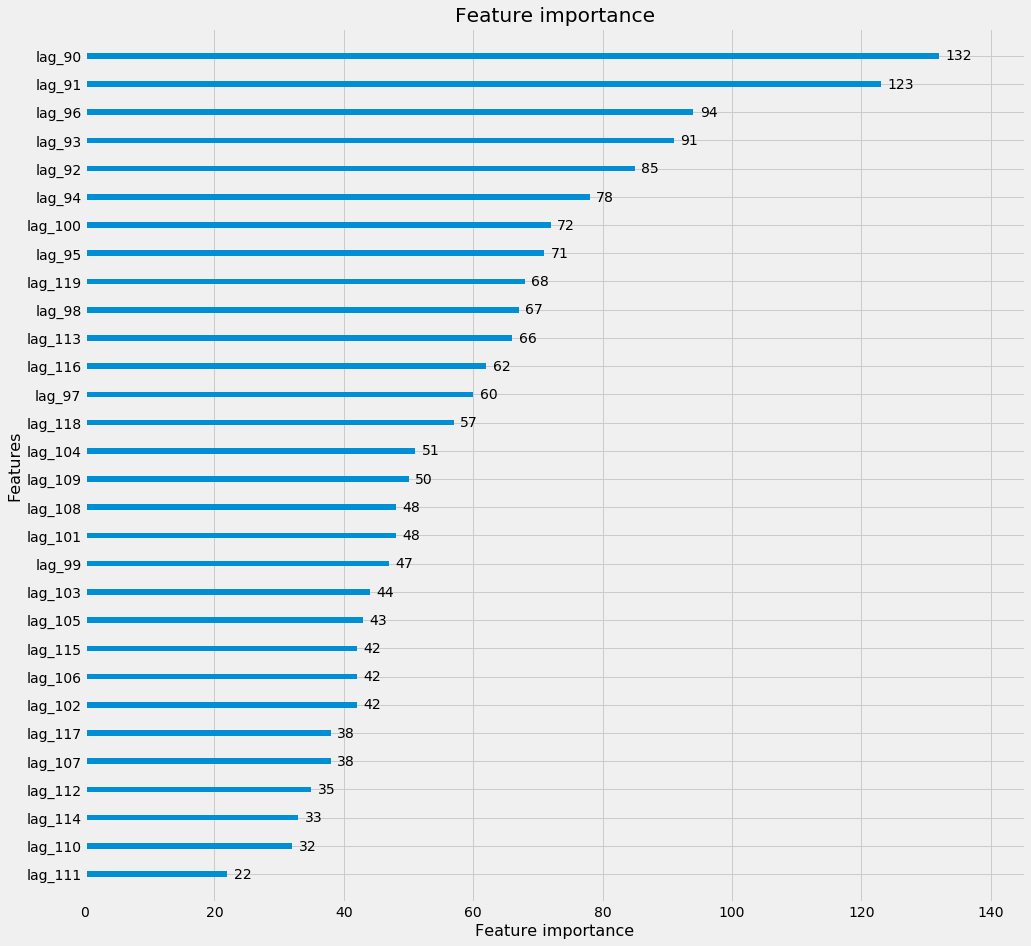

In [22]:
lgb.plot_importance(clf, figsize=(15,15))

In [23]:
prediction = np.mean(preds, axis=0)

In [24]:
# root_mean_squared_error(test[target], prediction)

In [25]:
submission = pd.DataFrame()
submission[target] = prediction
submission.to_excel("submission_lgb_v2.xlsx", index=None)
submission.head()

,GrocerySales
0,8757.269706
1,8778.873653
2,8835.569653
3,8844.319472
4,8920.697897


In [26]:
submission[target].describe()

count    90.000000  
mean     8781.881170
std      72.333136  
min      8604.706207
25%      8737.847759
50%      8778.522075
75%      8832.321929
max      8920.697897
Name: GrocerySales, dtype: float64